# Linear Regression pt 2
****

If we look at the visualizations in the visualizations notebook, we know that each each feature, when plotted against 'logerror,' are symmetric about the $y$-axis. This means that, individually, each line of best fit will be near to $y=0$ and so the residuals will be closely related to those of the distribution of 'logerror.'

In [2]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math
import scipy.stats as stats
import sklearn

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.core.display import display, HTML
#display(HTML("<style>.rendered_html{font-size: 18px; line-height: 1.4}</style>"))

In [4]:
Housing = pd.read_csv('cleaned_1.csv')
Housing = Housing.set_index(['parcelid','Unnamed: 0'])
Housing['transactiondate'] = pd.to_datetime(Housing['transactiondate'], format = '%Y-%m-%d', errors = 'coerce')
imp_cols = ['calculatedfinishedsquarefeet', 'latitude','longitude','lotsizesquarefeet','bathroomcnt',
         'taxamount','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','landtaxvaluedollarcnt',
         'yearbuilt', 'bedroomcnt','buildingqualitytypeid','regionidzip','rawcensustractandblock',
         'regionidneighborhood']#'tax_deviation'
# Save tax_deviation for regression

X_df = Housing[imp_cols]
Y_df = Housing['logerror']
#Housing.info()

We first note two distributions of 'logerror.' The standard distribution shows the vast majority of entries around 0, showing more that $y=0$ is the most likely line of best fit. The other distribution is in log scale to show two clusters we want to try to model.

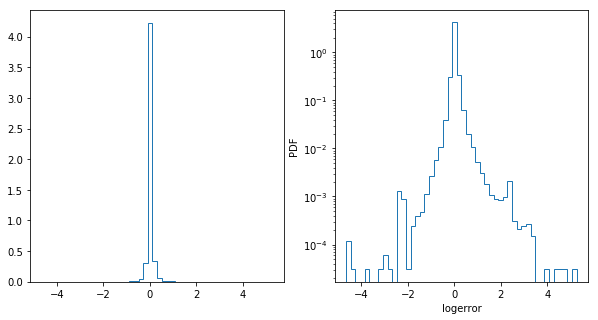

In [5]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot the linear_data on the 5th subplot axes 

ax1.hist(Housing['logerror'], bins=50, density=True, histtype='step')
#ax1 = plt.yscale('log')
ax1 = plt.xlabel('logerror')
ax1 = plt.ylabel('PDF')

ax2.hist(Housing['logerror'], bins=50, density=True, histtype='step')
ax2 = plt.yscale('log')
ax2 = plt.xlabel('logerror')
ax2 = plt.ylabel('PDF')

We will next do a cursory fit of 'calculatedfinishedsquarefeet' only with a linear regression.

In [6]:
linstr = ('logerror ~ calculatedfinishedsquarefeet + latitude + longitude + lotsizesquarefeet + bathroomcnt + '
          'taxamount + structuretaxvaluedollarcnt + tax_deviation + taxvaluedollarcnt + landtaxvaluedollarcnt + '
          'yearbuilt + bedroomcnt + buildingqualitytypeid + regionidzip + rawcensustractandblock + '
          'regionidneighborhood'
         )

In [7]:
sqft_reg = ols('logerror ~ calculatedfinishedsquarefeet',Housing).fit()
print(sqft_reg.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     233.8
Date:                Mon, 17 Sep 2018   Prob (F-statistic):           9.84e-53
Time:                        21:20:52   Log-Likelihood:                 65189.
No. Observations:              166532   AIC:                        -1.304e+05
Df Residuals:                  166530   BIC:                        -1.304e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

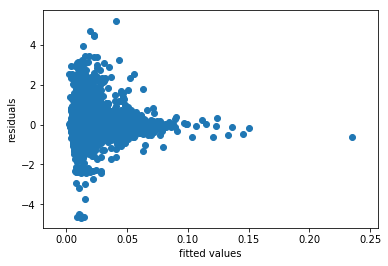

In [8]:
plt.figure()
plt.xlabel("fitted values")
plt.ylabel("residuals")
plt.scatter(sqft_reg.fittedvalues,sqft_reg.resid)

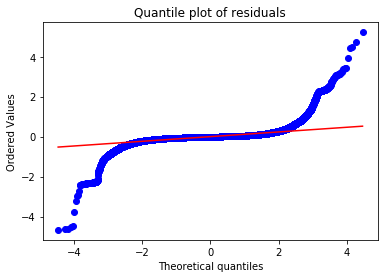

In [9]:
import pylab
plt.figure()
stats.probplot(sqft_reg.resid, dist="norm", plot=pylab)
pylab.title("Quantile plot of residuals")
pylab.show()

In [10]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [ 1.12801132e-05  4.34816753e-10  1.73983981e-09  1.81837828e-08
 -9.52844045e-04 -3.12520468e-06 -1.06689410e-07  1.25755778e-07
 -9.58254113e-08  1.99343394e-05  6.54002331e-04 -2.49151965e-04
  7.19372767e-08  3.83679019e-10  3.06752311e-09]
linear model intercept (b): 0.123
R-squared score (training): 0.004
R-squared score (test): 0.003


As we guessed, there is a poor linear regression for this one variable. So we will try a polynomial regression.

In [11]:
from sklearn.preprocessing import PolynomialFeatures
degree_range = [1,3,6,9]
range_under_6 = range(0,5)

# This fucntion does the polynomial transformation alone and spits out an array of transformed
# data for each degree. It is kept seperate in case I dont want to transform every time I fit.
# For now, it is not being used.

def build_transforms(degrees, train, test):
    #X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0)
    transformed_train = []
    for i in degrees:
        X_train_poly = PolynomialFeatures(degree=i).fit_transform(train)
        transformed_train.append(X_train_poly)

    transformed_test = []
    for i in degrees:
        X_test_poly = PolynomialFeatures(degree=i).fit_transform(test)
        transformed_test.append(X_test_poly)
        
    return transformed_train, transformed_test

#transformed_train, transformed_test = build_transforms(degree_range)

In [12]:
from sklearn.metrics.regression import r2_score

def r2train_full(i, X_train, y_train): # this function transforms and fits
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    linreg = LinearRegression().fit(X_train_poly, y_train)
        
    r2_train = linreg.score(X_train_poly, y_train)
    return r2_train

def r2train(i, tf_X, y_train): 
    # in case the transforming func is used, apply this func (not currently being used.)
    linreg = LinearRegression().fit(tf_X[i], y_train)
        
    r2_train = linreg.score(tf_X[i], y_train)
    return r2_train

r2_train_list = []
for i in range_under_6:
    r2_train_list.append(r2train_full(i, X_train, y_train))
    #r2_train_list.append(r2train(i))
    
r2_train = np.array(r2_train_list)

print('the r2 scores for degrees ', range_under_6, ' on the training set are ', r2_train)

the r2 scores for degrees  range(0, 5)  on the training set are  [0.         0.0037029  0.00992103 0.02661988 0.04396717]


In [13]:
def r2test_full(i, X_train, X_test, y_train, y_test):  # this function transforms and fits
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    linreg = LinearRegression().fit(X_train_poly, y_train)
        
    r2_test = linreg.score(X_test_poly, y_test)
    return r2_test

def r2test(i, tf_tr, tf_ts, y_train, y_test): 
    # in case the transforming func is used, apply this func (not currently being used.)
    linreg = LinearRegression().fit(tf_tr[i], y_train)
        
    r2_test = linreg.score(tf_ts[i], y_test)
    return r2_test

r2_test_list = []
for i in range_under_6:
    #r2_test_list.append(r2test(i))
    r2_test_list.append(r2test_full(i, X_train, X_test, y_train, y_test))
    
r2_test = np.array(r2_test_list)
print('the r2 scores for degrees ', range_under_6, ' on the test set are ', r2_test)   

the r2 scores for degrees  range(0, 5)  on the test set are  [-1.48751561e-04  2.82714028e-03 -4.95072123e-03 -2.07389283e+02
 -9.19806616e+04]


We note that degree 4 is the best fit, though it is still not very good, in fact are quite similar to the linear regression. We will try to use the other features, beginning with the smaller dataset.
****
## Polynomial regressions on Housing
****
begin with a ridge regression

In [15]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Housing dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Housing dataset
ridge regression linear model intercept: -0.0064217107744063175
ridge regression linear model coeff:
[ 0.19709832  0.0003175   0.00666755  0.08072398  0.01553163 -0.13257087
 -0.05213669 -0.04492169 -0.03999844  0.00241937  0.0263384  -0.00277979
  0.00885391  0.00422714  0.00213767]
R-squared score (training): 0.002
R-squared score (test): 0.001
Number of non-zero features: 15


We perform a Lasso regression using a chosen degree

In [ ]:
from sklearn.linear_model import Lasso
best_degree = 4

def LinLasso(i):
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
        
    linlasso = Lasso(alpha=0.1, max_iter = 10000).fit(X_train_poly, y_train)
        
    r2_test = linlasso.score(X_test_poly, y_test)
    return r2_test

#print('For degree 12, lassos score is ', LinLasso(12))
print('For degree ',best_degree,' lassos score is ', LinLasso(best_degree))

Now, we do a neural network regressor.

In [ ]:
from sklearn.neural_network import MLPRegressor

mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                      activation = thisactivation,
                      alpha = thisalpha,
                      solver = 'lbfgs').fit(X_train, y_train)
print('Housing dataset')
print('ridge regression linear model intercept: {}'
     .format(mlpreg.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(mlpreg.coef_))
print('R-squared score (training): {:.3f}'
     .format(mlpreg.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(mlpreg.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(mlpreg.coef_ != 0)))